#### <b>Problem 1. 나만의 모델을 만들어 학습 및 평가하기</b>

* 나만의 GAN 모델을 이용해 <b>최대한 높은 FID 점수</b>를 받아보세요.
    * (Hint) 200 epochs 이상으로 학습해보기
    * (Hint) DCGAN의 아키텍처를 효율적으로 바꿔보기
    * (Hint) WGAN 등 [다른 아키텍처들을](https://github.com/eriklindernoren/PyTorch-GAN) 적용해보기
    * (Hint) 사전 학습된(pre-trained) GAN 모델 사용해보기
* 결과적으로 자신이 학습한 모델의 <b>최종 FID 점수(score)를 작성</b>하세요.
    * 마스크 착용 및 미착용 이미지를 <b>각각 1,000장씩 생성</b>하여 FID를 계산합니다.
    * 마스크 착용: {답을 쓰세요.}
    * 마스크 미착용: {답을 쓰세요.}
* 결과 이미지의 해상도는 1 X 64 X 64가 되어야 합니다.

In [4]:
!git clone https://github.com/ndb796/Face-Mask-Classification-20000-Dataset

Cloning into 'Face-Mask-Classification-20000-Dataset'...
remote: Enumerating objects: 20017, done.
remote: Total 20017 (delta 0), reused 0 (delta 0), pack-reused 20017
Receiving objects: 100% (20017/20017), 600.78 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (20001/20001), done.


In [5]:

import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])




data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

!mkdir -p ./results/custom/

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


In [6]:
latent_dim = 100
n_classes = 2


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.init_size = 4
        self.layer1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 512 * self.init_size * self.init_size)) 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        # 노이즈(noise) 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        output = self.layer1(inputs)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output


# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 1),
        )

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, 1 * 64* 64)

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        # 이미지 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        embed = self.label_embed(labels).view((img.size(0), 1, 64,64))
        inputs = torch.cat((img, embed), 1)
        output = self.conv_blocks(inputs)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

In [7]:
from torch.autograd import Variable
import torch.autograd as autograd
Tensor = torch.cuda.FloatTensor
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates,labels)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [9]:
def critic_loss(r_logit, f_logit):
    real_loss = - torch.mean(r_logit)
    fake_loss = torch.mean(f_logit)
    return real_loss, fake_loss

def generator_loss(f_logit):
    fake_loss = - torch.mean(f_logit)
    return fake_loss

In [11]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
generator = Generator()
generator.cuda()
generator.load_state_dict(torch.load("CustomGenerator.pt"))
discriminator.load_state_dict(torch.load("CustomDiscriminator.pt"))

In [ ]:

import time

n_epochs = 500 # 학습의 횟수(epoch) 설정
sample_interval = 1000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
critic_n = 5
lambda_gp = 10
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()
        generated_imgs = generator(z,generated_labels)
        # 판별자(discriminator)의 손실(loss) 값 계산
        real_logit = discriminator(real_imgs, labels)
        fake_logit = discriminator(generated_imgs.detach(), generated_labels)

        real_loss, fake_loss = critic_loss(real_logit, fake_logit)
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, generated_imgs.data, generated_labels)
        d_loss = (real_loss + fake_loss) +lambda_gp * gradient_penalty
        

        # 판별자(discriminator) 업데이트
        d_loss.backward()

        optimizer_D.step()

        if i % critic_n == 0:

            """ 생성자(generator)를 학습합니다. """
            optimizer_G.zero_grad()

            # 이미지 생성
            generated_imgs = generator(z, generated_labels)
            # 생성자(generator)의 손실(loss) 값 계산
            g_loss = generator_loss(discriminator(generated_imgs, generated_labels))
            # 생성자(generator) 업데이트
            g_loss.backward()
            optimizer_G.step()
        
        

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = generator(z, labels)
            save_image(generated_imgs, f"./results/custom/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

In [14]:
torch.save(generator.state_dict(), "CustomGenerator.pt")
torch.save(discriminator.state_dict(), "CustomDiscriminator.pt")

In [15]:
!mkdir ./results/custom/with_mask/
!mkdir ./results/custom/without_mask/

In [16]:
generator = Generator()
generator.cuda()
generator.load_state_dict(torch.load("CustomGenerator.pt"))

<All keys matched successfully>

In [17]:
# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/custom/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용하지 않은 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/custom/without_mask/{i * 100 + j}.png', normalize=True)

In [18]:
!git clone https://github.com/hukkelas/pytorch-frechet-inception-distance

Cloning into 'pytorch-frechet-inception-distance'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.


In [ ]:
# 평가 수행
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/custom/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/custom/without_mask/*.png
Looking for images in ./results/custom/without_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: 

In [ ]:
# 평가 수행
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/custom/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/custom/with_mask/*.png
Looking for images in ./results/custom/with_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
349.387956651986


In [ ]:
# ./results/custom/ 폴더의 모든 파일을 results.zip라는 이름으로 압축
!zip ./results.zip -r ./results/custom/*

In [22]:
# Google Colab으로부터 results.zip 압축 파일 다운로드
from google.colab import files

files.download('./results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
files.download('./CustomDiscriminator.pt')
files.download('./CustomGenerator.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* PPT에 들어갈 내용
    1. 최종적으로 얻은 점수 (마스크 미착용 FID 점수 + 마스크 착용 FID 점수)
    2. 좋은 결과를 만들기 위해 어떤 전략을 사용했는지, 그 이유는 무엇인지
    3. 소스코드에서 핵심이 되는 부분 캡처 사진 및 설명
    4. 자신의 GAN에서 생성된 이미지들 캡처 사진
* 점수 판정 기준
    * <b>FID의 점수 합이 가장 작은 팀</b>이 1등입니다.
    * 마스크 미착용 FID 점수 = 171.67이고, 마스크 착용 FID 점수 = 114.97이라면?
    * 최종 점수 = 171.67 + 114.97 = 286.64
* 최종적으로 <b>팀 단위로 제출할 파일</b>은 다음과 같습니다.
    1. PPT 파일: 사용한 모델과 최종적인 FID 점수에 대한 설명을 포함하기
    2. Colab Notebook 파일: <b>[파일]</b> - <b>[다운로드]</b> - <b>[.ipynb 다운로드]</b>
    3. 최종 결과 이미지(마스크 착용 1,000개 및 마스크 미착용 1,000개)가 포함된 압축 파일
* 최종 결과 이미지는 다음과 같은 양식으로 압축 파일(.zip) 형태로 제출합니다.
    * with_mask와 without_mask 이미지들이 서로 다른 폴더로 확실히 구분되어야 합니다.
    * <b>PPT에 기록된 FID 점수와 동일한 점수</b>가 나오는 이미지여야 합니다.

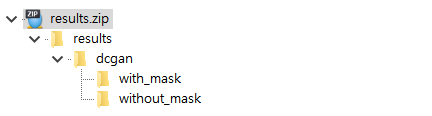

* GAN은 학습이 어려운 네트워크 중 하나입니다.
    * 학습 자체가 안 되는 문제가 발생할 수 있습니다. (처음부터 D loss: 0.5, G loss: 1.0 고정되는 문제)
    * 같은 레이블에 대하여 거의 똑같은 이미지만 생성될 수 있습니다. (mode collapse)
* (Hint) 학습이 잘 안 되는 경우 배치 사이즈, learning rate, 아키텍처를 다시 확인하고 조절합니다.
* FID 점수는 이미지 생성을 할 때마다 변경될 수 있습니다.
    * 실제로 해당 FID 점수가 나왔는지 확인할 필요가 있으므로, 생성된 이미지 파일(총 2,000장)을 꼭 함께 제출합니다.